In [35]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import math
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os.path
import os

# Setup

In [36]:
with_obstacles = True

data_from = ''
path = "G:/Bachelor/Data" + data_from

csv = ".csv"

def getConstants(path):
    name = 'constants.csv'
    constants = pd.read_csv(f"{path}/{name}")
    out = {}
    out['stationary_t'] = int(constants['stationary_t'])
    out['avg'] = int(constants['avg'])
    out['delta_t'] = float(constants['delta_t'])
    out['a'] = int(constants['a'])
    out['w'] = int(constants['w'])
    out['h'] = int(constants['h'])
    out['num_particles'] = int(constants['num_particles'])
    out['m'] = int(constants['m'])
    out['k_BT'] = float(constants['k_BT'])
    out['g'] = float(constants['g'])
    if 'last_timestep' in constants.columns:
        out['last_timestep'] = constants['last_timestep']
    return out

constants = getConstants(path)
x_dim = constants['w']
y_dim = constants['h']
stationary = constants['stationary_t']

## Load

In [ ]:
def load_obstacles(parent):
        obstacles_path = f'{parent}/constants_obstacles.csv'
        obstacles_csv = pd.read_csv(obstacles_path)
        print('Loaded obstacles!')
        return obstacles_csv
    

def get_last_timestep(parent):
    if 'last_timestep' in constants:
        return constants['last_timestep']
    else:
    
        filenames_monomers = glob.glob(f'{parent}/monomers_av*.csv')
        last = filenames_monomers[-1]
        num_last = int(last.split("timestep")[1].replace(".csv", "")) - 1

        os.remove(last)

        particles_filename = f'{parent}/particles_av{constants["avg"]}_timestep0{num_last+1}.csv'
        if os.path.exists(particles_filename):
            os.remove(particles_filename)
            print("Deleted last (maybe incomplete) particles file)")

        cells_filename = f'{parent}/cells_av{constants["avg"]}_timestep0{num_last+1}.csv'
        if os.path.exists(cells_filename):
            os.remove(cells_filename)
            print("Deleted last (maybe incomplete) cells file)")
        
        constants['last_timestep'] = num_last
        df = pd.DataFrame(constants, index = [0])
        df.to_csv(f'{parent}/constants.csv', index = False)
        
        print('Saved new constants file')

        return num_last

def load_monomers(parent, constants):
    monomers_t = []

    # Loading particles
    print('Loading Monomers ..')
    filenames_monomers = glob.glob(f'{parent}/monomers_av*.csv')
    for it, file in enumerate(filenames_monomers):
        monomers_t.append(pd.read_csv(file))
        if (it % 500 == 0):
            print('--loaded {}'.format(it))
    print('Monomers loaded and saved!\n')
    # Monomers loaded
    return monomers_t


def load_particles(parent):
    particles_stationary = pd.read_csv(f'{parent}/particles_av{constants["avg"]}_timestep0{stationary-1}.csv')
    print('Particles loaded.\n')
    
    return particles_stationary

def load_cells(parent):
    print('Loading cells')
    cells_timesteps = []

    filenames_cells = glob.glob(f'{parent}/cells_av*.csv'.format(path))
    for it, file in enumerate(filenames_cells):
        df = pd.read_csv(file)
        cells_timesteps.append(df)
        if (it % 500 == 0):
            print('--loaded {}'.format(it))
        it += 1
    print('Cells loaded and saved!\n')
    # Cells loaded
    return cells_timesteps
    
parent_dir = path
num_timesteps = get_last_timestep(parent_dir)
monomers_t = load_monomers(parent_dir, constants)
#particles = load_particles(parent_dir)
cells_timesteps = load_cells(parent_dir)

obstacles = []
if (with_obstacles):
    obstacles = load_obstacles(parent_dir)

Saved new constants file
Loading Monomers ..
--loaded 0
--loaded 500
--loaded 1000
--loaded 1500
--loaded 2000


In [ ]:
def add_obstacles(obstacles, axis):
     for index, o in obstacles.iterrows():
        circle = plt.Circle((o['x'], o['y']), int(obstacles['r'][0]), color = 'black')
        axis.add_artist(circle)
        

point_size = 3
for it, df in enumerate(monomers_t):
    if (it % 100 == 0):
        fig, ax = plt.subplots(figsize = (15,2))
        if with_obstacles:
            add_obstacles(obstacles, ax)
           
        ax.plot(df['x'], df['y'], 'o', markersize = point_size, color = 'red')
        ax.set_xlim((0, 400))
        ax.set_ylim((0, 20))
        #plt.savefig(f"Test/monomer_plot_{it}.png")
        plt.show()

# Plot

In [26]:
x_region = (0, x_dim)
y_region = (0, y_dim)

def process_plotdata(x_region, y_region):
    x0_obstacles = x_region[0]
    x1_obstacles = x_region[1]
    y0_obstacles = y_region[0]
    y1_obstacles = y_region[1]
    x = np.arange(x0_obstacles, x1_obstacles)
    y = np.arange(y0_obstacles, y1_obstacles)
    X, Y = np.meshgrid(x, y)
    cells = cells_timesteps[-1].set_index(['i', 'j'])
    vx = np.array([[cells['meanX'].loc[row, col] for col in x] for row in y])
    vy = np.array([[cells['meanY'].loc[row, col] for col in x] for row in y])
    pivot = cells.reset_index().pivot(index = 'i', columns = 'j', values = 'num')
    return X, Y, vx, vy, pivot

X, Y, vx, vy, pivot = process_plotdata(x_region, y_region)

# Plot settings
streamplot_density = 2
point_size = 0.3
color = np.sqrt(vx**2 + vy**2)
plot_x_region = (x_region[0] - 1, x_region[1])
plot_y_region = (y_region[0] - 1, y_region[1])

cells = cells_timesteps[-1]
cells['speed'] = np.sqrt(cells['meanX']**2 + cells['meanY']**2)
speed_pivot = cells.pivot(index = "i", columns = "j", values = 'speed')

j        0         1         2         3         4         5         6    \
i                                                                          
0   0.235427  0.615739  0.059953  0.391886  0.337632  0.156625  0.174671   
1   0.328800  0.990979  0.285075  0.361755  0.549709  0.691449  0.427067   
2   0.279530  0.691136  0.299922  0.864085  0.834422  0.563069  0.540668   
3   0.172214  0.424189  0.950514  0.394081  1.340179  0.719607  0.815641   
4   0.186950  0.683868  0.286865  0.339588  0.135899  0.980517  0.388203   
5   0.165468  0.149913  0.151273  0.025128  0.606773  1.100709  1.334668   
6   0.845971  0.966740  0.840971  0.530491  0.238007  0.630364  0.378654   
7   0.461791  0.651792  0.587452  1.422456  0.649650  0.583701  0.551939   
8   0.572405  0.373204  0.342049  0.277177  1.862901  0.568177  0.470457   
9   0.640089  0.519118  0.337271  0.932405  0.607570  0.651254  0.552917   
10  0.440660  0.287140  0.363838  0.801046  0.734435  0.771389  0.196243   
11  0.357686

Plotting data ..
Data plotted and saved!


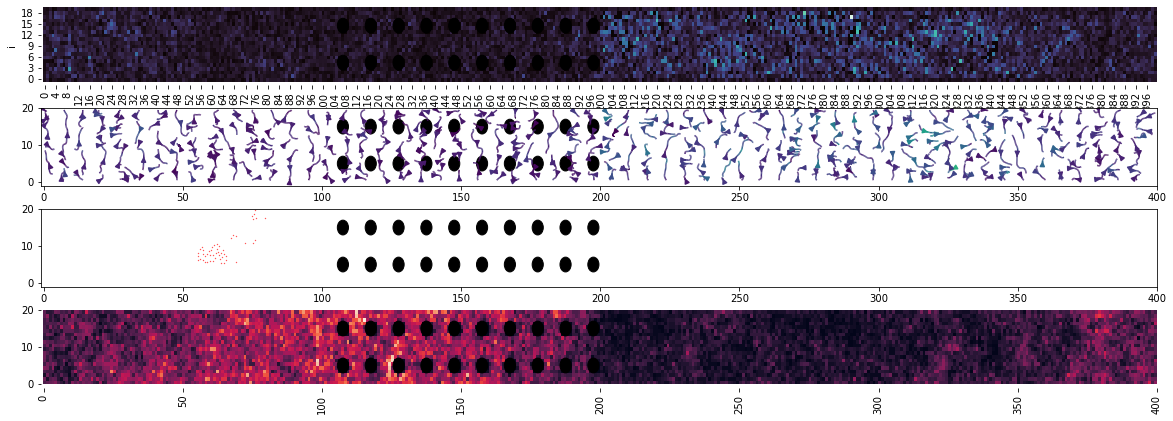

In [28]:
print('Plotting data ..')
fig = plt.figure(figsize=(20,7))
ax = [fig.add_subplot(4,1,i+1) for i in range(4)]
    
fig.subplots_adjust(wspace=0, hspace=0.3)

if with_obstacles:
    add_obstacles(obstacles, ax[0])
    add_obstacles(obstacles, ax[1])
    add_obstacles(obstacles, ax[2])
    add_obstacles(obstacles, ax[3])
    
yticks = np.linspace(0, 20, num=3, dtype=np.int)
yticklabels = [str(t) for t in yticks]
xticks = np.linspace(0, 400, num=9, dtype=np.int)
xticklabels = [str(t) for t in xticks]

#ax[0].quiver(X + 0.5, Y + 0.5, vx, vy, color)
sns.heatmap(speed_pivot, ax = ax[0], cmap = 'mako', cbar = False)
ax[0].set(xlim=plot_x_region, ylim=plot_y_region)
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(yticklabels)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticklabels)

ax[1].streamplot(X + 0.5, Y + 0.5, vx, vy, color=color, density=streamplot_density) # grid
ax[1].set(xlim=plot_x_region, ylim=plot_y_region)

#ax[2].plot(particles['x'], particles['y'], "o", markersize = point_size)
monomers = monomers_t[-1]
ax[2].plot(monomers['x'], monomers['y'], 'o', markersize = point_size, color = 'red')
ax[2].set(xlim=plot_x_region, ylim=plot_y_region)

sns.heatmap(pivot, ax=ax[3], cbar = False) # cbar_kws={"fraction": 0.046, "pad": 0.005}
ax[3].set(xlim=plot_x_region, ylim=plot_y_region)
ax[3].set_ylabel('')
ax[3].set_xlabel('')

ax[3].set_yticks(yticks)
ax[3].set_yticklabels(yticklabels)
ax[3].set_xticks(xticks)
ax[3].set_xticklabels(xticklabels)

plt.savefig("Assets/stationary_region.png")
#plt.close()
print('Data plotted and saved!')

# Reality Check

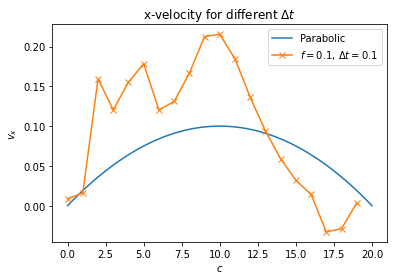

In [29]:
def viscosity(v_max, m = 1, av_N_c = 10, g = 0.01, D = 50):
    return (m * av_N_c * g * D**2) / (8 * v_max)

def parabolic_flow(y, D, v_max = 0.1):
    return (4 * v_max * (D - y) * y)/(D**2)
    

y = np.linspace(0, y_dim, 100)
plt.plot(y, parabolic_flow(y, y_dim), label = 'Parabolic')

data_dirs = [''] #400x50_0.01g_0.05t/', '400x50_0.01g_0.1t/', '400x50_0.01g_0.15t/', '400x50_0.01g_0.2t/'
for config in data_dirs:
    cells = cells_timesteps[-1].set_index(['i', 'j'])
    velocities_i = cells['meanX'].groupby('i').mean()
    plt.plot(velocities_i, '-x', label = '$f = {}$, $\Delta t = {}$'.format(constants['g'], constants['delta_t']))#.mean(axis = 1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('x-velocity for different $\Delta t$')
plt.ylabel('$v_x$')
plt.xlabel('$c$')
#plt.savefig('Assets/poseuille.png')
plt.show()

NameError: name 'particles' is not defined

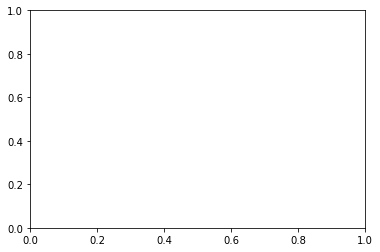

In [30]:
def theoretical_dist(Delta_v, N_c, av_N_c = 10, m = 1, k_B = 1, T = 1):
    A = (m/(2 * math.pi * k_B * T * (1 - 1/N_c)))**(3/2)
    B = np.exp(-(m/(2 * k_B * T * (1 - 1/N_c))) * Delta_v**2)
    return A * B

def poisson_avg(Delta_v, max_sum = 1000, av_N_c = 10, m = 1, k_B = 1, T = 1):
    e = math.exp(-av_N_c)
    total = 0
    for N_c in range(2, max_sum):
        P = (av_N_c**N_c)/(math.factorial(N_c))
        N = theoretical_dist(Delta_v, N_c, m, k_B, T)
        total += P * (N)
    D = 1 - (av_N_c + 1) * e
    return e * total/D

data_dirs = [''] #400x50_0.01g_0.05t/, '400x50_0.01g_0.1t/', '400x50_0.01g_0.15t/', '400x50_0.01g_0.2t/'
fig, ax = plt.subplots(nrows = 1, ncols = 1)
for config in data_dirs:
    particles["i"] = (particles["y"] / constants["a"]).apply(lambda i: floor(i))
    particles["j"] = (particles["x"] / constants["a"]).apply(lambda i: floor(i))
    complete = pd.merge(particles, cells, how = 'inner', on = ["i", "j"])
    complete["Delta_vx"] = complete["vx"] - complete["meanX"]
    complete["Delta_vy"] = complete["vy"] - complete["meanY"]
    complete["Delta_v"] = np.sqrt(complete["Delta_vx"]**2 + complete["Delta_vy"]**2)
    mid_i = (particles["i"] >= 1/4*y_dim) & (particles["i"] <= 35)
    subselection = complete.loc[mid_i]
    sns.kdeplot(subselection["Delta_v"]/ math.sqrt(constants["k_BT"] / constants["m"]),
                ax = ax, label = '$g = {}$, $\Delta t = {}$'.format(constants["g"], constants["delta_t"]))
    #ax.plot(subselection["Delta_v"], poisson_avg(subselection["Delta_v"]/ math.sqrt(constants["k_BT"] / constants["m"])), 'o')# ,ax = ax
ax.legend()
ax.set_title('Distribution of velocity in a cell')
ax.set_ylabel('Frequency')
ax.set_xlabel('$|\Delta v|$')
plt.savefig("Assets/Delta_v_dist.png")
plt.show()

# Monomer animation

--Created 0 frame.

--Created 0 frame.

--Created 0 frame.



KeyboardInterrupt: 

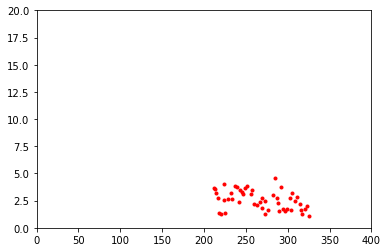

In [13]:
from matplotlib import animation

fig = plt.figure()
ax = plt.axes(xlim=(0, 400), ylim=(0, 20))

point_size = 3
df = monomers_t[0]
scatter, = ax.plot(df['x'], df['y'], 'o', markersize = point_size, color = 'red')

# animation function.  This is called sequentially
def animate(it):
    df = monomers_t[it]
    scatter.set_xdata(df['x'])
    scatter.set_ydata(df['y'])
    if (it % 100 == 0):
        print('--Created {} frame.\n'.format(it))
    return scatter,

anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=len(monomers_t), blit=True)

anim.save('./Assets/monomer_animation.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
print('Animated and saved!')

plt.show()
#plt.close()

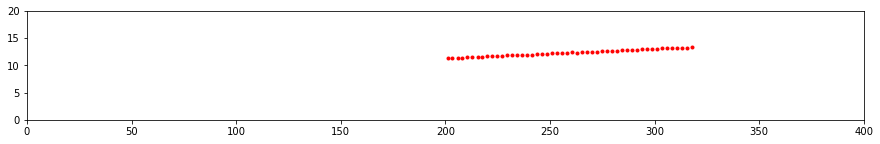

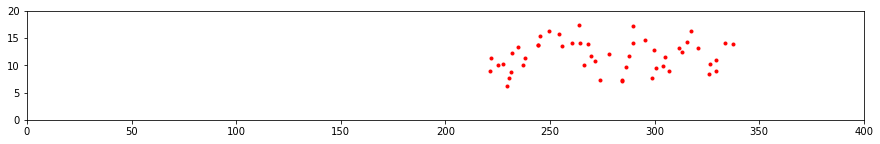

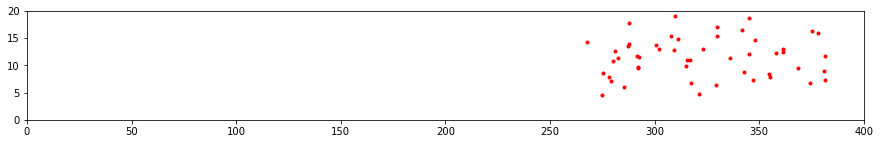

In [13]:
point_size = 3
for it, df in enumerate(monomers_t):
    if (it % 200 == 0):
        plt.figure(figsize = (15,2))
        scatter = plt.plot(df['x'], df['y'], 'o', markersize = point_size, color = 'red')
        plt.xlim((0, 400))
        plt.ylim((0, 20))
        plt.savefig(f"Test/monomer_plot_{it}.png")
        plt.show()


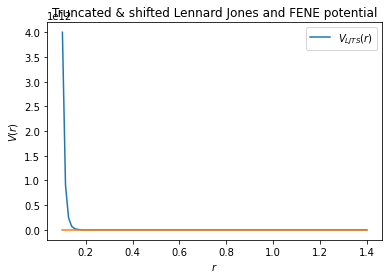

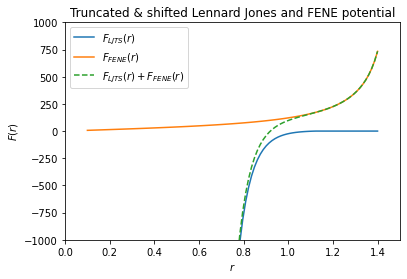

In [2]:
def V_LJTS(d, tuning, diameter, r_end):
    f = [V_LJ(r, tuning, diameter) - V_LJ(r_end, tuning, diameter) if r <= r_end else 0 for r in d]
    return f

def V_LJ(d, tuning, diameter):
    return 4 * tuning * ((diameter**12) / (d**12) - (diameter**6) / (d**6));

def V_FENE(d, tuning, diameter, k, R0):
    f = k/2 * tuning / (diameter**2) * R0**2 * np.log(1 - d**2/(1.5**2))
    return f

# --------- PARAMETERS ---------- #
tuning = 1
diameter = 1
r_end = 2**(1/6) * diameter
R0 = 1.5 * diameter
k = 30
d = np.linspace(0.1, 1.4, 100)


# -------- POTENTIAL PLOTTING ------- #
plt.plot(d, V_LJTS(d, tuning, diameter, r_end), label = '$V_{LJTS}(r)$')
plt.plot(d, [1 for n in d])
#plt.plot(d, V_FENE(d, tuning, diameter, k, R0), label = '$V_{FENE}(r)$')
#plt.plot(d, V_LJTS(d, tuning, diameter, r_end) + V_FENE(d, tuning, diameter, k, R0), '--', label = '$V_{LJTS}(r) + V_{FENE}(r)$')
#plt.xlim(0, 1.5)
plt.xlabel('$r$')
#plt.ylim(-1000, 1000)
plt.ylabel('$V(r)$')
plt.title('Truncated & shifted Lennard Jones and FENE potential')
plt.legend()
plt.show()

def LJ_trunc(d, tuning, diameter, r_end):
    f = [LJ(r, tuning, diameter) if r <= r_end else 0 for r in d] #- LJ(r_end, tuning, diameter)
    return f
    
def LJ(d, tuning, diameter):
    return 4 * tuning * (-12 * (diameter**12) / (d**13) - (-6 * diameter**6) / (d**7));

def FENE(d, tuning, diameter, k, R0):
    f = k * tuning/(diameter**2) * R0**2 * d/(1 - (d/R0)**2)
    return f

# ---------- FORCE PLOTTING --------- #
plt.plot(d, LJ_trunc(d, tuning, diameter, r_end), label = '$F_{LJTS}(r)$')
plt.plot(d, FENE(d, tuning, diameter, k, R0), label = '$F_{FENE}(r)$')
plt.plot(d, LJ_trunc(d, tuning, diameter, r_end) + FENE(d, tuning, diameter, k, R0), '--', label = '$F_{LJTS}(r) + F_{FENE}(r)$')
plt.xlim(0, 1.5)
plt.xlabel('$r$')
plt.ylim(-1000, 1000)
plt.ylabel('$F(r)$')
plt.title('Truncated & shifted Lennard Jones and FENE potential')
plt.legend()
plt.show()